In [1]:
import datetime
SK_CASES_BY_DAY =   [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,0,3,11,11,12,17,11,25,8,19,14,41,7]
INTERVENTION_DAYS = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1, 1, 1, 0, 0, 0, 0,0, 0, 0, 0,0]
DATES = [datetime.date(2020,3,21) - datetime.timedelta(days=len(SK_CASES_BY_DAY)-i-1) for i in range(len(SK_CASES_BY_DAY))]

DATES, list(enumerate(INTERVENTION_DAYS))

([datetime.date(2020, 2, 20),
  datetime.date(2020, 2, 21),
  datetime.date(2020, 2, 22),
  datetime.date(2020, 2, 23),
  datetime.date(2020, 2, 24),
  datetime.date(2020, 2, 25),
  datetime.date(2020, 2, 26),
  datetime.date(2020, 2, 27),
  datetime.date(2020, 2, 28),
  datetime.date(2020, 2, 29),
  datetime.date(2020, 3, 1),
  datetime.date(2020, 3, 2),
  datetime.date(2020, 3, 3),
  datetime.date(2020, 3, 4),
  datetime.date(2020, 3, 5),
  datetime.date(2020, 3, 6),
  datetime.date(2020, 3, 7),
  datetime.date(2020, 3, 8),
  datetime.date(2020, 3, 9),
  datetime.date(2020, 3, 10),
  datetime.date(2020, 3, 11),
  datetime.date(2020, 3, 12),
  datetime.date(2020, 3, 13),
  datetime.date(2020, 3, 14),
  datetime.date(2020, 3, 15),
  datetime.date(2020, 3, 16),
  datetime.date(2020, 3, 17),
  datetime.date(2020, 3, 18),
  datetime.date(2020, 3, 19),
  datetime.date(2020, 3, 20),
  datetime.date(2020, 3, 21)],
 [(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (4, 0),
  (5, 0),
  (6, 0),
  (7, 0)

In [2]:
INTER_START = 17
INTER_END = 22

In [3]:
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/usamec/anaconda3/envs/covid/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
import pymc3 as pm
import numpy as np
import theano
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [5]:
# optimization should be o3 here, otherwise things will get slow
# use 
# export THEANO_FLAGS='optimizer=o3'
print(theano.config.optimizer)

o3


In [30]:
def run_simul(cases, interventions, import_mean=5, import_std=5, beta_std_factor=2, obs_kernel=[0,0,0,0,1,2,3,4,5,4,3,2,1]):
    """
    cases - number of reported cases for each day 
    intervetions - 1 if there was interventions, 0 otherwise for each day
    intervention_alpha - alpha cooeficient in Beta distribution for intervention (higger value, means that interventions are weaker)
    import_mean, import_std - mean and std for imported cases
    beta_std_factor - deviation for rate of new local infections
    obs_kernel - transformation vector for real case to observations (how many cases are seen at day I, I+1, I+2, ...)
    """
    with pm.Model() as model:
        beta_start = pm.Uniform('beta_start', 0.2, 0.4)
        beta_end = pm.Uniform('beta_end', 0.0, beta_start)
        beta = beta_start # R0 = beta/gamma (podla SIR modelu)
        gamma = 0.1
        infected = 0

        daily_cases = []
        betas = []

        for day in range(len(cases)):
            if day < INTER_START:
                beta = pm.Deterministic('beta_%s' % day, beta_start)
            elif day < INTER_END:
                beta = pm.Uniform('beta_%s' % day, beta_end, beta_start)
            else:
                beta = pm.Deterministic('beta_%s' % day, beta_end)
            
            imported_cases = pm.TruncatedNormal('day_import_%s' % day, import_mean, import_std, lower=0) # another wildass guess
            betas.append(beta)
            
            beta_lower = beta - beta / beta_std_factor
            beta_upper = beta + beta / beta_std_factor
            #print(beta_std_factor)
            # this is not ideal, but should not matter much
            daily_beta = pm.Uniform('day_beta_%s' % day, beta_lower, beta_upper)

            new_local_infections = infected * daily_beta # We assume infinite population (SIR model multiplies this with susceptible / total pop.)
            today = pm.Deterministic('day_%s' % day, imported_cases + new_local_infections)
            today_recovered = infected * gamma
            infected = infected + today - today_recovered
            daily_cases.append(today)

        # and now delayed and shitty reporting
        daily_stacked = pm.Deterministic('daily', pm.math.stack(daily_cases))
        betas_stacked = pm.Deterministic('betas', pm.math.stack(betas))
        R = pm.Deterministic('R', betas_stacked / gamma)
        kernel = np.array(obs_kernel, dtype=np.float32)
        kernel /= np.sum(kernel)
        shift = np.zeros((len(daily_cases), len(daily_cases)+len(kernel)))
        for i in range(len(daily_cases)):
            shift[i,i:i+len(kernel)] = kernel
        #print(shift)
        expected_observed = pm.Deterministic('exp_obs', pm.math.dot(daily_stacked, shift))[:-len(kernel)]
        # division by 6 just for shitty reporting (and maybe here poisson distribution is bad idea)
        observed = pm.Poisson('obs', mu=expected_observed / 6.0, observed=cases)


        trace = pm.sample(2000, chains=4, cores=2)
        return trace

In [31]:
"""
My observations about parameters:
- lenght of kernel sort of matters, concrete values not that much
- import_mean and import_std should be high enough otherwise, model that to have high starting R
"""
settings = [
    (8, 8, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
    (8, 32, 4, (0,0,0,0,1,2,3,3,3,3,3,3,3,2,1)),
]

In [32]:
new_results2 = {}
for s in settings:
    print(s)
    new_results2[s] = run_simul(SK_CASES_BY_DAY, INTERVENTION_DAYS, *s)

(8, 8, 4, (0, 0, 0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 2, 1))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [day_beta_30, day_import_30, day_beta_29, day_import_29, day_beta_28, day_import_28, day_beta_27, day_import_27, day_beta_26, day_import_26, day_beta_25, day_import_25, day_beta_24, day_import_24, day_beta_23, day_import_23, day_beta_22, day_import_22, day_beta_21, day_import_21, beta_21, day_beta_20, day_import_20, beta_20, day_beta_19, day_import_19, beta_19, day_beta_18, day_import_18, beta_18, day_beta_17, day_import_17, beta_17, day_beta_16, day_import_16, day_beta_15, day_import_15, day_beta_14, day_import_14, day_beta_13, day_import_13, day_beta_12, day_import_12, day_beta_11, day_import_11, day_beta_10, day_import_10, day_beta_9, day_import_9, day_beta_8, day_import_8, day_beta_7, day_import_7, day_beta_6, day_import_6, day_beta_5, day_import_5, day_beta_4, day_import_4, day_beta_3, day_import_3, day_beta_2, day_import_2, day_beta_1, day_import_1, day_bet

(8, 32, 4, (0, 0, 0, 0, 1, 2, 3, 3, 3, 3, 3, 3, 3, 2, 1))


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [day_beta_30, day_import_30, day_beta_29, day_import_29, day_beta_28, day_import_28, day_beta_27, day_import_27, day_beta_26, day_import_26, day_beta_25, day_import_25, day_beta_24, day_import_24, day_beta_23, day_import_23, day_beta_22, day_import_22, day_beta_21, day_import_21, beta_21, day_beta_20, day_import_20, beta_20, day_beta_19, day_import_19, beta_19, day_beta_18, day_import_18, beta_18, day_beta_17, day_import_17, beta_17, day_beta_16, day_import_16, day_beta_15, day_import_15, day_beta_14, day_import_14, day_beta_13, day_import_13, day_beta_12, day_import_12, day_beta_11, day_import_11, day_beta_10, day_import_10, day_beta_9, day_import_9, day_beta_8, day_import_8, day_beta_7, day_import_7, day_beta_6, day_import_6, day_beta_5, day_import_5, day_beta_4, day_import_4, day_beta_3, day_import_3, day_beta_2, day_import_2, day_beta_1, day_import_1, day_bet

In [33]:
plt.rcParams['figure.figsize'] = [10, 5]

In [34]:
def plot_trace(trace, key, label, color, alpha75=0.1, alpha95=0.1):
    our_dates = DATES[:trace[key].shape[1]]
    plt.plot(our_dates, np.median(trace[key], axis=0), label=label, color=color)
    plt.fill_between(our_dates, np.percentile(trace[key], 2.5, axis=0), np.percentile(trace[key], 97.5, axis=0), alpha=alpha95,  color=color)
    plt.fill_between(our_dates, np.percentile(trace[key], 25, axis=0), np.percentile(trace[key], 75, axis=0), alpha=alpha75,  color=color)


In [23]:
colors = list(mcolors.TABLEAU_COLORS.keys())
colors[0]

'tab:blue'

/home/usamec/anaconda3/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


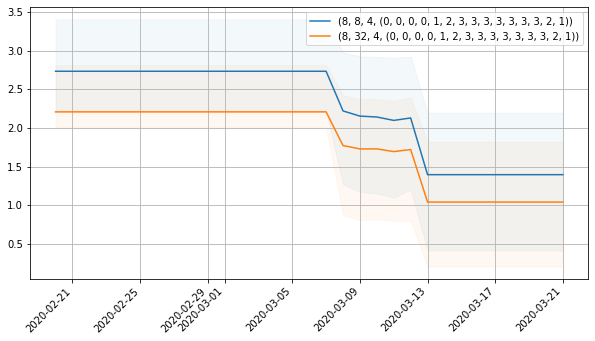

In [36]:
for i, (x, trace) in enumerate(new_results2.items()):
    plot_trace(trace, "R", label=str(x), color=colors[i], alpha75=0, alpha95=0.05)
plt.grid(True)
plt.legend()
for l in plt.axes().get_xticklabels():
    l.set_rotation(45)
    l.set_horizontalalignment('right')

/home/usamec/anaconda3/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


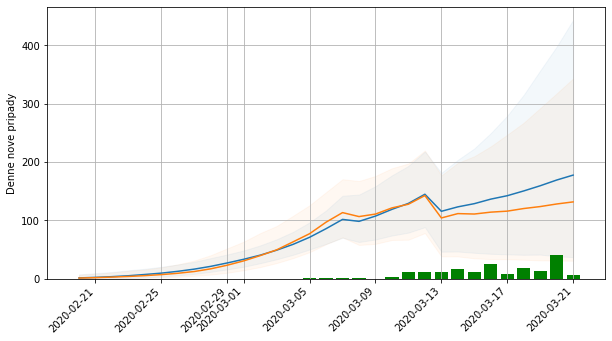

In [38]:
for i, (x, trace) in enumerate(new_results2x.items()):
    plot_trace(trace, "daily", label=str(x), color=colors[i], alpha75=0.0, alpha95=0.05)
plt.grid(True)
plt.bar(DATES, (SK_CASES_BY_DAY), label="reported cases", color="green")
#plt.yscale("log")
plt.ylabel("Denne nove pripady")
for l in plt.axes().get_xticklabels():
    l.set_rotation(45)
    l.set_horizontalalignment('right')

In [27]:
all_Rs = np.vstack([trace["R"] for trace in new_results2x.values()])
all_Rs.shape

(16000, 31)

In [28]:
# starting R
np.percentile(all_Rs, 2.5, axis=0)[0], np.percentile(all_Rs, 25, axis=0)[0], np.percentile(all_Rs, 50, axis=0)[0], np.percentile(all_Rs, 75, axis=0)[0], np.percentile(all_Rs, 97.5, axis=0)[0]

(2.020741240405434,
 2.2204302880776474,
 2.4422255985888723,
 2.680110708991434,
 3.1084406040672166)

In [29]:
# final R
np.percentile(all_Rs, 2.5, axis=0)[-1], np.percentile(all_Rs, 25, axis=0)[-1], np.percentile(all_Rs, 50, axis=0)[-1], np.percentile(all_Rs, 75, axis=0)[-1], np.percentile(all_Rs, 97.5, axis=0)[-1]

(0.2827082138351934,
 0.8902986708020421,
 1.2284039849430635,
 1.5789160628564773,
 2.1311473746005336)